# AIM

In this notebook we would be training an LSTM model for slot tagging on ATIS-2 dataset. We would be using test dataset for evaluating our modelling as well. You can find the sample of data available in the data folder, but due to licensing issue I cannot post the complete dataset over there.

<img src="">

## Loading the required libraries for the task

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn_crfsuite.metrics import flat_classification_report, flat_f1_score
import matplotlib.pyplot as plt

torch.manual_seed(1)

Using TensorFlow backend.


## Loading train, validation and test dataset

In [62]:
# Here we have written a quick function to load the data. 
# The function loads the data into a dataframe, seperating the Query,Tags for each of 
# the word in the tag and Label which is the intent of the query

def load_data(file):
    with open(file, 'r') as f:
        data = f.readlines()
    
    query, tags, label = [], [], []
    for dp in data:
        query.append(dp.split("\t")[0].strip().split(" "))
        tags.append(dp.split("\t")[1].strip().split(" ")[0:-1])
        label.append(dp.split("\t")[1].strip().split(" ")[-1])
       
    df = pd.DataFrame({"Query": query, "Tags": tags, "Label": label})
    
    return df

# Load triaing data
df_1 = load_data("data/atis.train.w-intent.iob")
df_2 = load_data("data/atis-2.train.w-intent.iob")
df_train = pd.concat([df_1, df_2])

# Load validation and test data
df_val = load_data("data/atis-2.dev.w-intent.iob")
df_test = load_data("data/atis.test.w-intent.iob")

## Supporting Functions

In [63]:
# train word to index dictionary, tag to index dictionary, 
# index to word dictionary and index to tag dictionary from the training data  

def train_dictoinary(df):
    word_to_ix, tag_to_ix = {'<PAD>': 0}, {'<PAD>': 0}
    ix_to_words, ix_to_tag = {0: '<PAD>'},  {0: '<PAD>'}
    
    for index, dp in df.iterrows():
        for word in dp.Query:
            if word not in word_to_ix:
                idx = len(word_to_ix)
                word_to_ix[word] = idx
                ix_to_words[idx] = word

        for tag in dp.Tags:
            if tag not in tag_to_ix:
                idx = len(tag_to_ix)
                tag_to_ix[tag] = idx
                ix_to_tag[idx] = tag
    
    return word_to_ix, tag_to_ix, ix_to_words, ix_to_tag

word_to_ix, tag_to_ix, ix_to_words, ix_to_tag = train_dictoinary(df_train)

In [64]:
# convert sequence of words to its corresponding sequence of indexes

def prepare_sequence(seq, to_ix):
    #idxs = [to_ix[w] for w in seq if not w == "EOS" and w in to_ix else 0.0]
    idxs = [to_ix[w] if w in to_ix else 0 for w in seq if not w == "EOS"]
    return idxs

In [65]:
# create batches of desired size for faster training, this would return a list of 
# dataframes where each dataframe is of the length of batch defined

def create_batches(df, batch_size=64):
    start_index, end_index = 0, 0 
    batches = []
    
    while True:
        start_index = end_index
        if end_index + batch_size > len(df):
            end_index = len(df)
        else:
            end_index = end_index + batch_size
            
        sentences, tags, sentences_len = [], [], []
        for index, dp in df[start_index:end_index].iterrows():
            sentences.append(prepare_sequence(dp.Query, word_to_ix))
            tags.append(prepare_sequence(dp.Tags, tag_to_ix))
            sentences_len.append(len(dp.Query))
        
        sentences_padded = pad_sequences(sentences, maxlen=48, padding='post')
        tags_padded = pad_sequences(tags, maxlen=48, padding='post')
        
        df_batch = pd.DataFrame({"Query": torch.tensor(sentences_padded, dtype=torch.long), \
                                 "Tags": torch.tensor(tags_padded, dtype=torch.long), \
                                 "Query_len": sentences_len})
        
        batches.append(df_batch)
        
        if end_index == len(df):
            break
            
    return batches

df_train = create_batches(df_train, batch_size=64)
df_val = create_batches(df_val, batch_size=len(df_val))

In [38]:
# Predict the tags of a single sentence.

def predict_single(sentence, ids_to_tags, model):
    # print (sentence)
    sentences_split = [prepare_sequence(sentence, word_to_ix)]
    sentences_padded = pad_sequences(sentences_split, maxlen=48, padding='post')
    sentences_len = [len(sentence)]
    
    tag_scores = model(torch.tensor(sentences_padded, dtype=torch.long), sentences_len)
    tag_scores = tag_scores.view(1, 48, -1)
    output = []
    value, tag_indexes = tag_scores[0].max(1)
    for i in range(len(sentence)-1):
        output.append(ids_to_tags[tag_indexes[i].item()])
    
    # print ("Tags --> {0}".format(" ".join(output)))
        
    return output

## Training Models

In [13]:
# Build a class of LSTM for training a unidirectional slot training model

class SlotTagger_LSTM(nn.Module):   
    def __init__(self, word_to_ix, tag_to_ix, lstm_layers=3, lstm_hidden_units=100, embedding_dim=20, dropout=0.2):
        super(SlotTagger_LSTM, self).__init__()
        self.word_to_ix = word_to_ix
        self.tag_to_ix = tag_to_ix
        
        self.word_count = len(self.word_to_ix)
        self.embedding_dim = embedding_dim
        self.lstm_layers = lstm_layers
        self.lstm_hidden_units = lstm_hidden_units
        self.output_dim = len(self.tag_to_ix)
        self.dropout = dropout
        
        padding_idx = self.word_to_ix['<PAD>']
        self.word_embedding = nn.Embedding(num_embeddings=self.word_count, \
                                           embedding_dim=self.embedding_dim, \
                                           padding_idx=padding_idx)

        self.lstm = nn.LSTM(input_size=self.embedding_dim, \
                            hidden_size=self.lstm_hidden_units, \
                            num_layers=self.lstm_layers, \
                            dropout = self.dropout, \
                            batch_first=True)

        self.linear = nn.Linear(self.lstm_hidden_units, self.output_dim)

        
    def init_hidden(self, batch_size):
        w = torch.Tensor(self.lstm_layers, batch_size, self.lstm_hidden_units)
        h0 = nn.init.xavier_uniform_(w, gain=nn.init.calculate_gain('relu'))
        
        w = torch.Tensor(self.lstm_layers, batch_size, self.lstm_hidden_units)
        c0 = nn.init.xavier_uniform_(w, gain=nn.init.calculate_gain('relu'))

        return (h0, c0)

    def forward(self, sentences, sen_lengths):
        batch_size, seq_len = sentences.size()
    
        self.hidden = self.init_hidden(batch_size)

        sentences = self.word_embedding(sentences)
        
        sentences = torch.nn.utils.rnn.pack_padded_sequence(sentences, sen_lengths, batch_first=True)
        lstm_output, _ = self.lstm(sentences, self.hidden)

        lstm_output, _ = torch.nn.utils.rnn.pad_packed_sequence(lstm_output, total_length=seq_len, batch_first=True)

        lstm_output = lstm_output.contiguous()
        lstm_output = lstm_output.view(-1, lstm_output.shape[2])

        output = self.linear(lstm_output)
        return F.log_softmax(output, dim=1)

model_LSTM = SlotTagger_LSTM(word_to_ix, tag_to_ix)
loss_function = nn.NLLLoss(ignore_index=0)
optimizer_LSTM = optim.SGD(model_LSTM.parameters(), lr=0.1)

In [14]:
# Build a class of LSTM for training a bidirectional slot training model

class SlotTagger_BiLSTM(nn.Module):   
    def __init__(self, word_to_ix, tag_to_ix, lstm_layers=3, lstm_hidden_units=100, embedding_dim=20, dropout=0.2):
        super(SlotTagger_BiLSTM, self).__init__()
        self.word_to_ix = word_to_ix
        self.tag_to_ix = tag_to_ix
        
        self.word_count = len(self.word_to_ix)
        self.embedding_dim = embedding_dim
        self.lstm_layers = lstm_layers
        self.lstm_hidden_units = lstm_hidden_units
        self.output_dim = len(self.tag_to_ix)
        self.dropout = dropout
        
        padding_idx = self.word_to_ix['<PAD>']
        self.word_embedding = nn.Embedding(num_embeddings=self.word_count, \
                                           embedding_dim=self.embedding_dim, \
                                           padding_idx=padding_idx)

        self.lstm = nn.LSTM(input_size=self.embedding_dim, \
                            hidden_size=self.lstm_hidden_units, \
                            num_layers=self.lstm_layers, \
                            dropout = self.dropout, \
                            bidirectional = True, \
                            batch_first=True)

        self.linear = nn.Linear(self.lstm_hidden_units*2, self.output_dim)

        
    def init_hidden(self, batch_size):
        w = torch.Tensor(self.lstm_layers*2, batch_size, self.lstm_hidden_units)
        h0 = nn.init.xavier_uniform_(w, gain=nn.init.calculate_gain('relu'))
        
        w = torch.Tensor(self.lstm_layers*2, batch_size, self.lstm_hidden_units)
        c0 = nn.init.xavier_uniform_(w, gain=nn.init.calculate_gain('relu'))

        return (h0, c0)

    def forward(self, sentences, sen_lengths):
        batch_size, seq_len = sentences.size()
    
        self.hidden = self.init_hidden(batch_size)

        sentences = self.word_embedding(sentences)
        sentences = torch.nn.utils.rnn.pack_padded_sequence(sentences, sen_lengths, batch_first=True)
        lstm_output, _ = self.lstm(sentences, self.hidden)

        lstm_output, _ = torch.nn.utils.rnn.pad_packed_sequence(lstm_output, total_length=seq_len, batch_first=True)

        lstm_output = lstm_output.contiguous()
        lstm_output = lstm_output.view(-1, lstm_output.shape[2])

        output = self.linear(lstm_output)
        return F.log_softmax(output, dim=1)

model_biLSTM = SlotTagger_BiLSTM(word_to_ix, tag_to_ix)
loss_function = nn.NLLLoss(ignore_index=0)
optimizer_biLSTM = optim.SGD(model_biLSTM.parameters(), lr=0.1)

In [15]:
# Function to calculate validation loss

def val_loss(df_val, model):
    
    validation_loss = 0.0
    for val in df_val:
        val.sort_values(["Query_len"], ascending=False, inplace=True)

        tag_scores = model(torch.tensor(val.Query), val.Query_len.tolist())
        targets = torch.tensor(val.Tags).view(-1)

        loss = loss_function(tag_scores, targets)
        validation_loss += loss.item()
    
    return validation_loss/float(len(df_val))

print (val_loss(df_val, model_LSTM))
print (val_loss(df_val, model_biLSTM))

4.80202054977417
4.809537887573242


In [56]:
# Predict the tags for a list of sentences

def predict(sentences, ids_to_tags, model):
    sentences_split = [prepare_sequence(sen.strip().split(" "), word_to_ix) for sen in sentences]
    sentences_padded = pad_sequences(sentences_split, maxlen=48, padding='post')
    sentences_len = [len(sen) for sen in sentences_split]
    
    tag_scores = model(torch.tensor(sentences_padded, dtype=torch.long), sentences_len)
    tag_scores = tag_scores.view(len(sentences), 48, -1)
    
    output = []
    for idoc, sen in enumerate(sentences):
        sentence_tags = []
        value, tag_indexes = tag_scores[idoc].max(1)
        for iword, word in enumerate(sen.split()):
            if word == "EOS":
                break
#                 sentence_tags.append(word)
            else:
                sentence_tags.append(ids_to_tags[tag_indexes[iword].item()])
   
        #print ("Sentence --> {0}".format(sen))
        #print ("Tags --> {0}".format(" ".join(sentence_tags)))
        
        output.append(sentence_tags)
    
    return output

predicted_slots = predict(["BOS on april first i need a ticket from tacoma to san jose departing before 7 am EOS"], \
                          ix_to_tag, \
                          model_biLSTM)

## Training Models - Unidirectional LSTM

In [18]:
training_loss, validation_loss = [], []

for epoch in range(200):
    epoch_loss = 0.0
    model_LSTM = model_LSTM.train()
    for batch in df_train:
        batch.sort_values(["Query_len"], ascending=False, inplace=True)
        model_LSTM.zero_grad()

        tag_scores = model_LSTM(torch.tensor(batch.Query), batch.Query_len.tolist())
        targets = torch.tensor(batch.Tags).view(-1)
        loss = loss_function(tag_scores, targets)
        
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer_LSTM.step()
    
    training_loss.append(epoch_loss/float(len(df_train)))
    model_LSTM = model_LSTM.eval()
    validation_loss.append(val_loss(df_val, model_LSTM))
#     if (epoch>2) and (training_loss[-2] - training_loss[-1]) / training_loss[-2] < 0.05:
#         break
    if epoch%10 == 0:
        print ("Epoch {0} -- Training_Loss {1:.4f} -- Validation_Loss {2:.4f}".format(epoch, training_loss[-1], validation_loss[-1]))

Epoch 0 -- Training_Loss 1.5853 -- Validation_Loss 1.6275
Epoch 10 -- Training_Loss 1.4223 -- Validation_Loss 1.4568
Epoch 20 -- Training_Loss 0.8871 -- Validation_Loss 0.9227
Epoch 30 -- Training_Loss 0.6887 -- Validation_Loss 0.7160
Epoch 40 -- Training_Loss 0.5684 -- Validation_Loss 0.5913
Epoch 50 -- Training_Loss 0.4724 -- Validation_Loss 0.4931
Epoch 60 -- Training_Loss 0.3948 -- Validation_Loss 0.4129
Epoch 70 -- Training_Loss 0.3347 -- Validation_Loss 0.3515
Epoch 80 -- Training_Loss 0.2894 -- Validation_Loss 0.3075
Epoch 90 -- Training_Loss 0.2527 -- Validation_Loss 0.2717
Epoch 100 -- Training_Loss 0.2249 -- Validation_Loss 0.2433
Epoch 110 -- Training_Loss 0.2021 -- Validation_Loss 0.2176
Epoch 120 -- Training_Loss 0.1826 -- Validation_Loss 0.1993
Epoch 130 -- Training_Loss 0.1668 -- Validation_Loss 0.1814
Epoch 140 -- Training_Loss 0.1549 -- Validation_Loss 0.1675
Epoch 150 -- Training_Loss 0.1418 -- Validation_Loss 0.1563
Epoch 160 -- Training_Loss 0.1309 -- Validation_Los

Text(0,0.5,'LOSS')

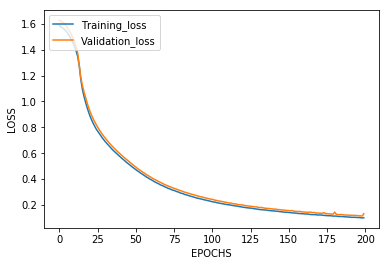

In [22]:
plt.plot(range(200), training_loss)
plt.plot(range(200), validation_loss)
plt.legend(['Training_loss', 'Validation_loss'], loc='upper left')
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")

In [23]:
sentences = ["BOS on april first i need a ticket from tacoma to san jose departing before 7 am EOS", \
             "BOS what ground transportation is available from dallas fort worth airport to downtown dallas EOS", \
             "BOS what does not sa mean EOS"]

model_LSTM = model_LSTM.eval()
predicted_slots = predict(sentences, ix_to_tag, model_LSTM)

Sentence --> BOS on april first i need a ticket from tacoma to san jose departing before 7 am EOS
Tags --> O O B-depart_date.month_name B-depart_date.day_number O O O O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name O B-depart_time.time_relative B-depart_time.time I-arrive_time.time
Sentence --> BOS what ground transportation is available from dallas fort worth airport to downtown dallas EOS
Tags --> O O O O O O O B-fromloc.city_name I-fromloc.city_name I-fromloc.city_name I-fromloc.airport_name O O B-toloc.city_name
Sentence --> BOS what does not sa mean EOS
Tags --> O O O B-airline_code B-fare_basis_code O


## Check performance on test data

In [51]:
predicted_tags = []
for index, dp in df_test.iterrows():
    predicted_tags.append(predict_single(dp.Query,ix_to_tag, model_LSTM))
    
report = flat_classification_report(df_test.Tags.tolist(), predicted_tags)
print (report)

/home/tushar/python36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                              precision    recall  f1-score   support

             B-aircraft_code       0.25      0.03      0.05        33
              B-airline_code       0.68      0.82      0.75        34
              B-airline_name       0.92      0.92      0.92       101
              B-airport_code       0.00      0.00      0.00         9
              B-airport_name       0.33      0.33      0.33        21
 B-arrive_date.date_relative       0.00      0.00      0.00         2
      B-arrive_date.day_name       0.29      0.91      0.44        11
    B-arrive_date.day_number       0.36      0.83      0.50         6
    B-arrive_date.month_name       0.45      0.83      0.59         6
      B-arrive_time.end_time       0.83      0.62      0.71         8
 B-arrive_time.period_of_day       0.31      0.83      0.45         6
    B-arrive_time.start_time       0.88      0.88      0.88         8
          B-arrive_time.time       0.72      0.85      0.78        34
 B-arrive_time.time

## Training Models - Bidirectional LSTM

In [46]:
training_loss, validation_loss = [], []

for epoch in range(200):
    epoch_loss = 0.0
    model_biLSTM = model_biLSTM.train()
    for batch in df_train:
        batch.sort_values(["Query_len"], ascending=False, inplace=True)
        model_biLSTM.zero_grad()

        tag_scores = model_biLSTM(torch.tensor(batch.Query), batch.Query_len.tolist())
        targets = torch.tensor(batch.Tags).view(-1)
        loss = loss_function(tag_scores, targets)
        
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer_biLSTM.step()
    
    training_loss.append(epoch_loss/float(len(df_train)))
    model_biLSTM = model_biLSTM.eval()
    validation_loss.append(val_loss(df_val, model_biLSTM))
#     if (epoch>2) and (training_loss[-2] - training_loss[-1]) / training_loss[-2] < 0.1:
#         break
    if epoch%10 == 0:
        print ("Epoch {0} -- Training_Loss {1:.4f} -- Validation_Loss {2:.4f}".format(epoch, training_loss[-1], validation_loss[-1]))

Epoch 0 -- Training_Loss 1.5272 -- Validation_Loss 1.5635
Epoch 10 -- Training_Loss 1.2319 -- Validation_Loss 1.2587
Epoch 20 -- Training_Loss 0.8212 -- Validation_Loss 0.8570
Epoch 30 -- Training_Loss 0.6275 -- Validation_Loss 0.6576
Epoch 40 -- Training_Loss 0.4730 -- Validation_Loss 0.4940
Epoch 50 -- Training_Loss 0.3678 -- Validation_Loss 0.3848
Epoch 60 -- Training_Loss 0.2903 -- Validation_Loss 0.3023
Epoch 70 -- Training_Loss 0.2335 -- Validation_Loss 0.2435
Epoch 80 -- Training_Loss 0.1918 -- Validation_Loss 0.2039
Epoch 90 -- Training_Loss 0.1612 -- Validation_Loss 0.1707
Epoch 100 -- Training_Loss 0.1375 -- Validation_Loss 0.1528
Epoch 110 -- Training_Loss 0.1168 -- Validation_Loss 0.1271
Epoch 120 -- Training_Loss 0.1012 -- Validation_Loss 0.1102
Epoch 130 -- Training_Loss 0.0880 -- Validation_Loss 0.0967
Epoch 140 -- Training_Loss 0.0777 -- Validation_Loss 0.0864
Epoch 150 -- Training_Loss 0.0681 -- Validation_Loss 0.0784
Epoch 160 -- Training_Loss 0.0606 -- Validation_Los

Text(0,0.5,'LOSS')

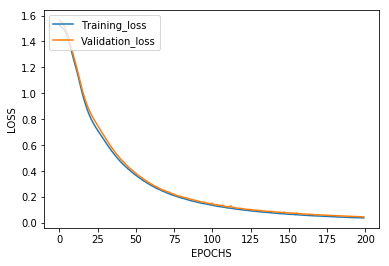

In [47]:
plt.plot(range(200), training_loss)
plt.plot(range(200), validation_loss)
plt.legend(['Training_loss', 'Validation_loss'], loc='upper left')
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")

In [48]:
sentences = ["BOS on april first i need a ticket from tacoma to san jose departing before 7 am EOS", \
             "BOS what ground transportation is available from dallas fort worth airport to downtown dallas EOS", \
             "BOS what does not sa mean EOS"]

model_biLSTM = model_biLSTM.eval()
predicted_slots = predict(sentences, ix_to_tag, model_biLSTM)

Sentence --> BOS on april first i need a ticket from tacoma to san jose departing before 7 am EOS
Tags --> O O B-depart_date.month_name B-depart_date.day_number O O O O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name O B-depart_time.time_relative B-depart_time.time I-depart_time.time
Sentence --> BOS what ground transportation is available from dallas fort worth airport to downtown dallas EOS
Tags --> O O O O O O O B-fromloc.airport_name I-fromloc.airport_name I-fromloc.airport_name I-fromloc.airport_name O O B-toloc.city_name
Sentence --> BOS what does not sa mean EOS
Tags --> O O O B-airline_code O O


## Compare performance on test data

In [49]:
predicted_tags = []
for index, dp in df_test.iterrows():
    predicted_tags.append(predict_single(dp.Query,ix_to_tag, model_biLSTM))
    
report = flat_classification_report(df_test.Tags.tolist(), predicted_tags)
print (report)

                              precision    recall  f1-score   support

             B-aircraft_code       1.00      0.18      0.31        33
              B-airline_code       0.79      1.00      0.88        34
              B-airline_name       0.99      0.94      0.96       101
              B-airport_code       0.57      0.44      0.50         9
              B-airport_name       0.75      0.29      0.41        21
 B-arrive_date.date_relative       0.00      0.00      0.00         2
      B-arrive_date.day_name       0.73      0.73      0.73        11
    B-arrive_date.day_number       0.62      0.83      0.71         6
    B-arrive_date.month_name       0.67      0.67      0.67         6
      B-arrive_time.end_time       1.00      1.00      1.00         8
 B-arrive_time.period_of_day       0.71      0.83      0.77         6
    B-arrive_time.start_time       1.00      1.00      1.00         8
          B-arrive_time.time       0.97      0.88      0.92        34
 B-arrive_time.time

# Diagnose ERROR on test data

In [53]:
def diagnose(df, ix_to_tag, model):
#     df["Query"] = [" ".join(sen) for sen in df.Query.tolist()]
#     df["Tags"] = [" ".join(tag) for tag in df.Tags.tolist()]
    
    extact_matches = 0
    not_extact_matches = 0
    
    sentence, predicted_tag, actual_tag = [], [], []
    for index, dp in df.iterrows():
        predicted = predict([" ".join(dp.Query)], ix_to_tag, model)[0]
        if check_macthes(predicted, dp.Tags):
            extact_matches += 1
        else:
            not_extact_matches += 1
            sentence.append(" ".join(dp.Query))
            predicted_tag.append(predicted)
            actual_tag.append(" ".join(dp.Tags))
    
    df_diagnose = pd.DataFrame({"Sentence": sentence, "Actul_Tag": actual_tag, "Predicted_Tag": predicted_tag})
    
    return df_diagnose, extact_matches, not_extact_matches
            
        
def check_macthes(predicted, actual):
    match = True
#     print (predicted)
#     print (actual)
    for pred, act in zip(predicted, actual):
        if pred == "BOS" or pred == "EOS":
            pass
        elif pred != act:
            match = False
            break
        else:
            pass
    
    return match

In [66]:
df_diagnose, extact_matches, not_extact_matches = diagnose(df_test, ix_to_tag, model_biLSTM)

df_diagnose.to_csv("Diagnose.csv")
print ("Sentences count where all slots were mathced : - ", extact_matches)
print ("Sentences count where all slots were not exact matched : -", not_extact_matches)

Sentences count where all slots were mathced : -  668
Sentences count where all slots were not exact matched : - 225
